<a href="https://colab.research.google.com/github/shubhi/Algorithms/blob/master/MSAI_437_HW2_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages**

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=9939abbf777803cb018ac1ae814b2adf54127f8c41c977e4f14664848f8d8352
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## **Data Processing**

Dataset: *HuggingFace - Emoji Dataset*

Link: [https://huggingface.co/datasets/valhalla/emoji-dataset](https://huggingface.co/datasets/valhalla/emoji-dataset)



### **Load Data from HuggingFace**

In [ ]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("valhalla/emoji-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds_builder.info.description
ds_builder.info.features

{'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}

In [ ]:
from datasets import get_dataset_split_names
get_dataset_split_names("valhalla/emoji-dataset")

['train']

In [ ]:
from datasets import load_dataset

dataset = load_dataset("valhalla/emoji-dataset")

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

In [ ]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'text': 'grinning face'}

### **Create subset of data based on categories with expressions/facial features**

In [ ]:
expression_categories = ["face", "vampire", "elf", "mage", "hero", "villain", "evil monkey", "zombie", "haircut", "juggling"]

subset = dataset['train'].filter(lambda example: any(category in example['text'] for category in expression_categories))

Filter:   0%|          | 0/2749 [00:00<?, ? examples/s]

Number of images related to expression categories: 342
Subset example: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0D884CC580>, 'text': 'cat face with tears of joy'}


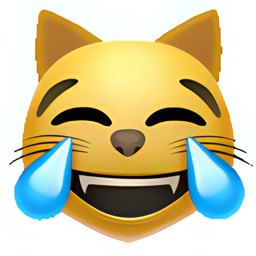

In [ ]:
import io
from IPython.display import display
print("Number of images related to expression categories:", len(subset))
print("Subset example:", subset[25])
image = subset[25]['image']
display(image)

### **Add class label "class_fiction"**

In [ ]:
def assign_class_label(example):
    fictional_descriptions = ["vampire", "elf", "mage", "hero", "villain", "zombie"]
    if any(description in example['text'] for description in fictional_descriptions):
        return {'text': example['text'], 'class_fiction': 'fictional', 'image': example['image']}
    else:
        return {'text': example['text'], 'class_fiction': 'non-fictional', 'image': example['image']}

In [ ]:
labeled_subset = [assign_class_label(example) for example in subset]

In [ ]:
print("Subset example:", labeled_subset[25])
print("Subset example:", labeled_subset[100])

Subset example: {'text': 'cat face with tears of joy', 'class_fiction': 'non-fictional', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0D884CFB80>}
Subset example: {'text': 'man elf dark skin tone', 'class_fiction': 'fictional', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0D884CF640>}


### **Set random seed at 42**

In [ ]:
import random
import numpy as np
import torch

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

### **Split Data 60/20/20**

In [ ]:
from torch.utils.data import random_split

In [ ]:
total_size = len(subset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

In [ ]:
train, val, test = random_split(labeled_subset, [train_size, val_size, test_size])

In [ ]:
print("Split Size:\n")
print("Train dataset size:", len(train))
print("Validation dataset size:", len(val))
print("Test dataset size:", len(test))

Split Size:

Train dataset size: 205
Validation dataset size: 68
Test dataset size: 69


### **Augment to 600/200/200**

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Random rotation up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with a probability of 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.1, 0.1))], p=0.5),  # Random affine transformation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Random Gaussian blur
])

In [ ]:
def augment_dataset(dataset, target_size):
    augmented_dataset = []
    while len(augmented_dataset) < target_size:
        for example in dataset:
            augmented_image = augmentation_transforms(example['image'])
            augmented_example = {'text': example['text'], 'class_fiction': example['class_fiction'], 'image': augmented_image}
            augmented_dataset.append(augmented_example)
            if len(augmented_dataset) >= target_size:
                break
    return augmented_dataset

In [ ]:
# Augment the train, validation, and test sets
train_aug = augment_dataset(train, 600)
val_aug = augment_dataset(val, 200)
test_aug = augment_dataset(test, 200)

In [ ]:
print("Augmented train dataset size:", len(train_aug))
print("Augmented validation dataset size:", len(val_aug))
print("Augmented test dataset size:", len(test_aug))

Augmented train dataset size: 600
Augmented validation dataset size: 200
Augmented test dataset size: 200


### **Resize to 64x64**

In [ ]:
resize_transform = transforms.Resize((64, 64))

In [ ]:
def resize_dataset(dataset):
    resized_dataset = []
    for example in dataset:
        resized_image = resize_transform(example['image'])
        resized_example = {'text': example['text'], 'class_fiction': example['class_fiction'], 'image': resized_image}
        resized_dataset.append(resized_example)
    return resized_dataset

In [ ]:
train_aug_resized = resize_dataset(train_aug)
val_aug_resized = resize_dataset(val_aug)
test_aug_resized = resize_dataset(test_aug)

## **End of data processing - final datasets**

In [ ]:
train_set = train_aug_resized
val_set = val_aug_resized
test_set = test_aug_resized

## **Autoencoder - Model and Training**

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Encoder layers
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#         )
#         # Decoder layers
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class Autoencoder_32(nn.Module):
    def __init__(self):
        super(Autoencoder_32, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder_64(nn.Module):
    def __init__(self):
        super(Autoencoder_64, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder_128(nn.Module):
    def __init__(self):
        super(Autoencoder_128, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [101]:
def train_autoencoder(train_set, val_set, latent_size, num_epochs=10, lr=0.001, weight_decay=1e-5):

    if latent_size == 32:
      model = Autoencoder_32()
    elif latent_size == 64:
      model = Autoencoder_64()
    elif latent_size == 128:
      model = Autoencoder_128()
    else:
      return

    #model = Autoencoder()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for t in train_set:
            optimizer.zero_grad()
            images = transforms.ToTensor()(t['image'])
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_set)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for v in val_set:
                images = transforms.ToTensor()(v['image'])
                outputs = model(images)
                loss = criterion(outputs, images)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_set)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return model, train_losses, val_losses

In [103]:
# Hyperparameters
latent_sizes = [32, 64, 128]  # Define latent sizes to be tuned
num_epochs=14
lr=0.001
weight_decay=1e-5

Training model with latent size: 32
Epoch [1/14], Train Loss: 0.1156, Val Loss: 0.0718
Epoch [2/14], Train Loss: 0.0383, Val Loss: 0.0481
Epoch [3/14], Train Loss: 0.0312, Val Loss: 0.0378
Epoch [4/14], Train Loss: 0.0251, Val Loss: 0.0219
Epoch [5/14], Train Loss: 0.0192, Val Loss: 0.0181
Epoch [6/14], Train Loss: 0.0170, Val Loss: 0.0164
Epoch [7/14], Train Loss: 0.0152, Val Loss: 0.0149
Epoch [8/14], Train Loss: 0.0138, Val Loss: 0.0138
Epoch [9/14], Train Loss: 0.0127, Val Loss: 0.0131
Epoch [10/14], Train Loss: 0.0120, Val Loss: 0.0126
Epoch [11/14], Train Loss: 0.0114, Val Loss: 0.0122
Epoch [12/14], Train Loss: 0.0109, Val Loss: 0.0119
Epoch [13/14], Train Loss: 0.0104, Val Loss: 0.0115
Epoch [14/14], Train Loss: 0.0100, Val Loss: 0.0113


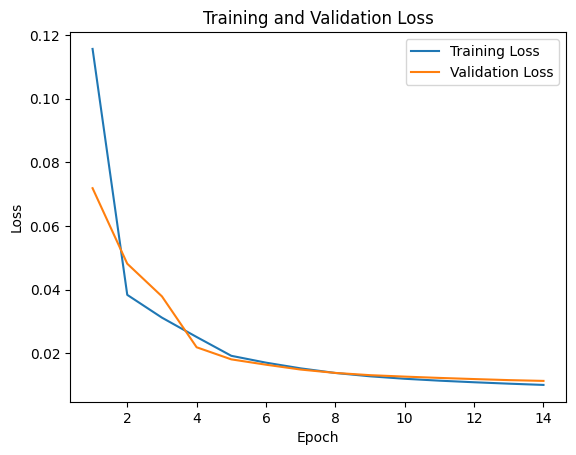

Training model with latent size: 64
Epoch [1/14], Train Loss: 0.1568, Val Loss: 0.1024
Epoch [2/14], Train Loss: 0.0662, Val Loss: 0.0637
Epoch [3/14], Train Loss: 0.0521, Val Loss: 0.0552
Epoch [4/14], Train Loss: 0.0421, Val Loss: 0.0457
Epoch [5/14], Train Loss: 0.0362, Val Loss: 0.0427
Epoch [6/14], Train Loss: 0.0324, Val Loss: 0.0631
Epoch [7/14], Train Loss: 0.0296, Val Loss: 0.0480
Epoch [8/14], Train Loss: 0.0274, Val Loss: 0.0311
Epoch [9/14], Train Loss: 0.0252, Val Loss: 0.0566
Epoch [10/14], Train Loss: 0.0207, Val Loss: 0.0282
Epoch [11/14], Train Loss: 0.0180, Val Loss: 0.0257
Epoch [12/14], Train Loss: 0.0168, Val Loss: 0.0270
Epoch [13/14], Train Loss: 0.0160, Val Loss: 0.0299
Epoch [14/14], Train Loss: 0.0154, Val Loss: 0.0281


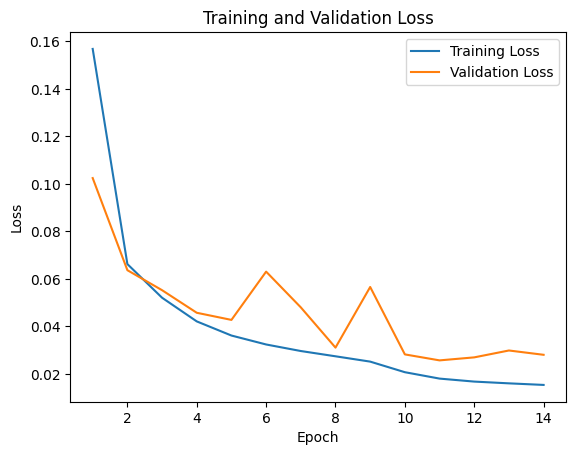

Training model with latent size: 128
Epoch [1/14], Train Loss: 0.2210, Val Loss: 0.1679
Epoch [2/14], Train Loss: 0.1162, Val Loss: 0.1136
Epoch [3/14], Train Loss: 0.0796, Val Loss: 0.0809
Epoch [4/14], Train Loss: 0.0658, Val Loss: 0.0640
Epoch [5/14], Train Loss: 0.0584, Val Loss: 0.0628
Epoch [6/14], Train Loss: 0.0544, Val Loss: 0.0680
Epoch [7/14], Train Loss: 0.0523, Val Loss: 0.0547
Epoch [8/14], Train Loss: 0.0482, Val Loss: 0.0551
Epoch [9/14], Train Loss: 0.0473, Val Loss: 0.0526
Epoch [10/14], Train Loss: 0.0448, Val Loss: 0.0491
Epoch [11/14], Train Loss: 0.0440, Val Loss: 0.0503
Epoch [12/14], Train Loss: 0.0425, Val Loss: 0.0483
Epoch [13/14], Train Loss: 0.0409, Val Loss: 0.0475
Epoch [14/14], Train Loss: 0.0401, Val Loss: 0.0479


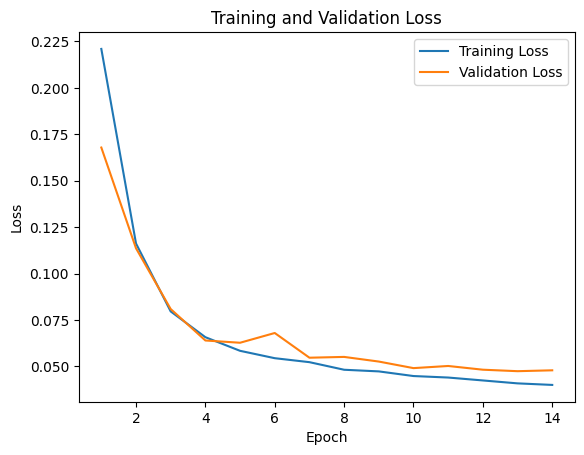

Best latent size: 32, Best validation loss: 0.0113


In [104]:
import matplotlib.pyplot as plt
best_val_loss = float('inf')
best_model = None
best_latent_size = None
best_train_losses = []
best_val_losses = []
for latent_size in latent_sizes:
    print(f'Training model with latent size: {latent_size}')
    model, train_losses, val_losses = train_autoencoder(train_set, val_set, latent_size, num_epochs, lr, weight_decay)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model = model
        best_latent_size = latent_size
        best_train_losses = train_losses
        best_val_losses = val_losses

print(f'Best latent size: {best_latent_size}, Best validation loss: {best_val_loss:.4f}')


## **End of Training: Save Best Model and Latent Represenatations**

In [109]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)

def save_latent_representations(model, dataset, filepath):
    model.eval()
    latent_reps = []
    with torch.no_grad():
        for t in dataset:
            images = transforms.ToTensor()(t['image'])
            latent_rep = model.encoder(images.unsqueeze(0))
            latent_reps.append(latent_rep.squeeze().numpy())
    np.save(filepath, np.array(latent_reps))

save_model_weights(best_model, 'autoencoder_weights.pth')
save_latent_representations(best_model, train_set, 'train_latent_reps.npy')
save_latent_representations(best_model, val_set, 'val_latent_reps.npy')
save_latent_representations(best_model, test_set, 'test_latent_reps.npy')

In [114]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
runtime_files = ['autoencoder_architecture.svg','autoencoder_weights.pth', 'train_latent_reps.npy', 'val_latent_reps.npy', 'test_latent_reps.npy']
drive_dir = '/content/drive/My Drive/Winter-2024/Deep-Learning'
for file in runtime_files:
    shutil.copy(file, drive_dir)

Mounted at /content/drive


## **Question 1: Implement and train your autoencoder on the subset of the Emoji dataset that you selected and augmented**


### **a. describe your dataset and the steps that you used to create it**

The dataset consists of images of emojis with associated text descriptions.

To create the dataset, we used the Huggingface Emoji dataset, which provides a collection of emoji images and their corresponding descriptions. We filtered the dataset to select a subset based on specific text descriptions such as "face," "vampire," "elf," "mage," etc.

We divided this subset into training, validation, and test sets using a 60/20/20 ratio. Data augmentation techniques such as rotation, flipping, and resizing were applied to increase the diversity of the dataset.

Finally, we resized the images to a resolution of 64x64x3 to reduce computational complexity.

### **b. provide a summary of your architecture**

The autoencoder architecture consists of an encoder and a decoder, each composed of several convolutional layers. The purpose of the autoencoder is to learn a compressed representation of the input data in the latent space and then reconstruct the original input from this compressed representation.

**Encoder:**
1.   The encoder takes the input image with 3 channels (for RGB) and applies a series of convolutional layers to progressively reduce the spatial dimensions of the input while increasing the depth.
2.   The first convolutional layer has 3 input channels (RGB) and produces 16 output channels using a kernel size of 3x3, a stride of 2, and padding of 1. This operation effectively downsamples the input image by a factor of 2 in each spatial dimension.
3.   Subsequent convolutional layers follow a similar pattern, increasing the number of output channels while maintaining the downsampling operation. This hierarchical feature extraction process captures increasingly abstract features of the input image with the final layer at 32.

**Decoder:**


1.   The decoder aims to reconstruct the original input image from the compressed representation learned by the encoder. It consists of transposed convolutional layers, also known as "deconvolution" or "upsampling" layers, which perform the opposite operation of convolutional layers by increasing the spatial dimensions while decreasing the depth.
2.   The first transposed convolutional layer takes the encoded representation with 32 channels and applies a transposed convolution operation to upsample it to a larger spatial size.
3.   Subsequent transposed convolutional layers continue to upsample the feature maps until the final output layer, which has 3 channels corresponding to the RGB channels of the reconstructed image.
4.   The output of the final layer is passed through a sigmoid activation function, squashing the pixel values between 0 and 1 to produce a valid image reconstruction.

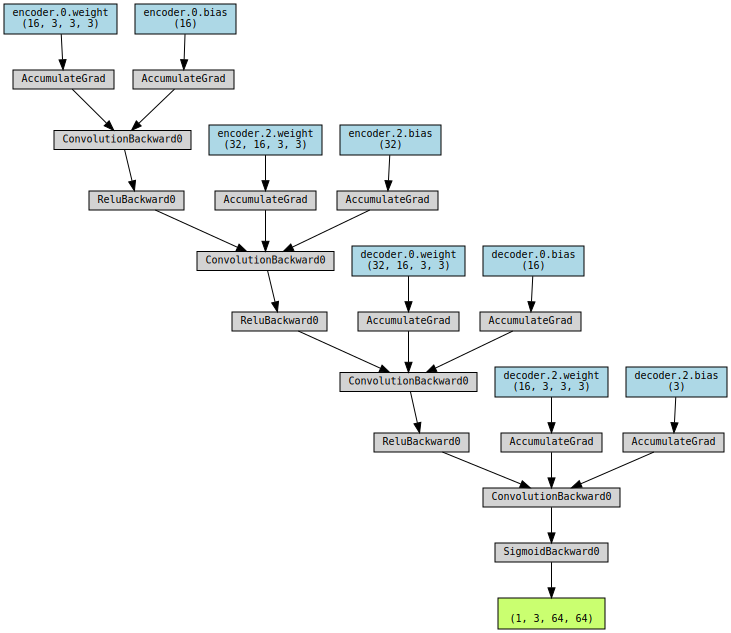

In [113]:
from torchviz import make_dot
dummy_input = torch.randn(1, 3, 64, 64)

output = best_model(dummy_input)
make_dot(output, params=dict(best_model.named_parameters()))
# dot = make_dot(output, params=dict(best_model.named_parameters()))
# dot.format = 'svg'
# dot.render('autoencoder_architecture')

### **c. discuss and explain your design choices**



*   **Convolutional Layers**: We chose convolutional layers for both the encoder and decoder to effectively capture spatial relationships in images.
*   **ReLU Activation**: ReLU activation functions were selected for their simplicity and effectiveness in introducing non-linearity to the network.
*   **Convolutional and Transposed Convolutional Layers**: Regular convolutional layers downsample input images in the encoder, while transposed convolutional layers upsample features in the decoder.
*   **Latent Space Dimensionality**: A latent space dimensionality of 32 was chosen to balance the level of compression and model complexity.
*   **Output Activation**: Sigmoid activation in the output layer ensures output images conform to a valid pixel value range.
*   **Model Complexity and Efficiency**: The architecture strikes a balance between model complexity and computational efficiency, optimizing performance while remaining tractable for training and inference.

### **d. list hyper-parameters used in the model**



*   **Learning Rate (lr)**: 0.001.
*   **Number of Epochs (num_epochs)**: 14 epochs.
*   **Latent Size**: 32.
*   **Regularization weight_decay**: 1e-5

### **e. plot learning curves for training and validation loss as a function of training epochs**

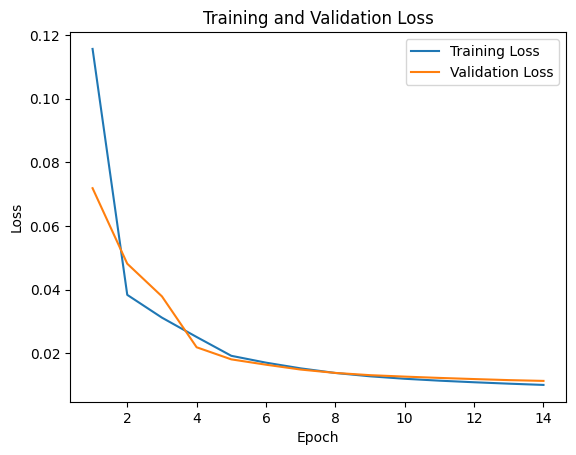

In [106]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), best_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### **f. provide the final average error of your autoencoder on your test set**

In [107]:
best_model.eval()
criterion = nn.MSELoss()
running_test_loss = 0.0
with torch.no_grad():
    for t in test_set:
        images = transforms.ToTensor()(t['image'])
        outputs = best_model(images)
        loss = criterion(outputs, images)
        running_test_loss += loss.item() * images.size(0)
test_loss = running_test_loss / len(test_set)

print(f'Final average error on the test set: {test_loss:.4f}')

Final average error on the test set: 0.0113


### PENDING **g. discuss any decisions or observations that you find relevant.**

## **Question 2:**

*(5.0 points)*

Separate your dataset into two or more classes using Emoji descriptions and assign labels. Repeat Step 1 adding image classification as an auxiliary task to MSE with a λ of your choosing.

You can choose any classification technique.



*   describe how you separated your dataset into classes
*   describe your classification technique and hyper-parameters
*   plot learning curves for training and validation loss for MSE and classification accuracy
*   discuss how incorporating classification as an auxiliary tasks impacts the performance of your autoencoder
*   speculate why performance changed and recommend (but do not implement) an experiment to confirm or reject your speculation.

### **a.   Describe how you separated your dataset into classes**


For separating the dataset into classes, we utilized the descriptions of emojis to categorize them into two classes: "**fictional**" and "**non-fictional**".

Emojis associated with descriptions like "*vampire*", "*elf*", "*mage*", etc., were labeled as "fictional", while those lacking such descriptors were categorized as "non-fictional".

This approach allowed us to create distinct class labels based on semantic information present in the emoji descriptions, facilitating the classification task.

In [ ]:
print("Subset example:", labeled_subset[25])
print("Subset example:", labeled_subset[100])

Subset example: {'text': 'cat face with tears of joy', 'class_fiction': 'non-fictional', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x78A86AB0C550>}
Subset example: {'text': 'man elf dark skin tone', 'class_fiction': 'fictional', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x78A86AB0EA70>}


### **b. Describe your classification technique and hyper-parameters**